# 英伟达价格预测 - 使用 Keras Tuner 的长短期记忆模型

## 目标

此项目的目的是训练一个 LSTM 模型，以便根据过去的时序数据预测英伟达股票的未来价格。此项目将使用 Keras 库中的 LSTM 模型。

## 什么是 LSTM？

LSTM 指的是长短期记忆网络，它属于深度学习领域的一部分。这是一种循环神经网络（RNN）的变体，能够学习长期依赖关系，尤其适用于序列预测问题。LSTM 具有反馈连接，也就是说，它能够处理整个数据序列，而不仅仅是像图像这样的单个数据点。因此，这种算法也这被应用于语音识别、机器翻译等领域。LSTM 是一种特殊的 RNN，它能在各种问题上表现出卓越的性能。

还是用M1的CPU算吧！

以后我再用Windows做AI开发我就是狗！！！

In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
tf.config.list_physical_devices('GPU')

# GPU 用这个
# tf.test.is_gpu_available()

[]

In [81]:
device_name = tf.config.list_physical_devices('CPU')[0].name
if device_name != '/physical_device:CPU:0':
    # raise SystemError('GPU device not found')
    print('No CPU Found')
print('Found CPU at: {}'.format(device_name))

# GPU 用这个
'''device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))'''

Found CPU at: /physical_device:CPU:0


"device_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n    raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))"

设置CPU为运算核心

In [82]:
tf.device(device_name)

# GPU 用这个
# tf.device('/device:GPU:0')

In [83]:
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

register_matplotlib_converters()
sns.set(font_scale=1.5, style="whitegrid")

## 加载数据

In [84]:
df = pd.read_csv('./NVidia_stock_data.csv')
df['Date'] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
df.head()

,Date,Close,High,Low,Open,Volume
0,1999-01-22,0.037607,0.044770,0.035577,0.040114,2714688000
1,1999-01-25,0.041547,0.042024,0.037607,0.040591,510480000
2,1999-01-26,0.038323,0.042860,0.037726,0.042024,343200000
3,1999-01-27,0.038204,0.039398,0.036293,0.038442,244368000
4,1999-01-28,0.038084,0.038442,0.037845,0.038204,227520000


In [85]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

创建多子图布局，每个股票属性（如开盘价、收盘价、成交量等）单独显示在一个子图中

生成专业图表，便于分析不同属性间的关联和趋势

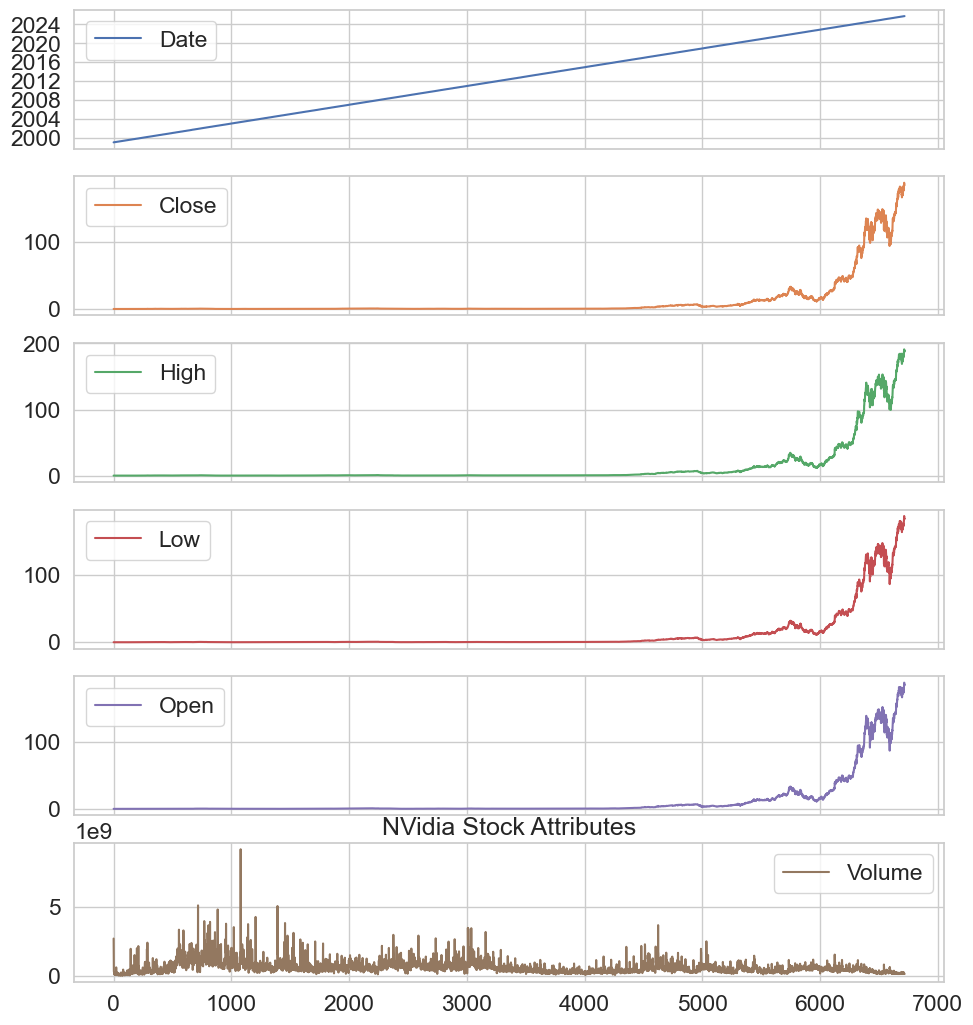

In [86]:
df.dropna(inplace=True)

df.plot(subplots = True, figsize = (10,12))
plt.title('NVidia Stock Attributes')
plt.show()

生成数据集的描述性统计信息

In [87]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,6719,6719.000000,6719.000000,6719.000000,6719.000000,6.719000e+03
mean,2012-05-29 05:57:41.765143552,12.052660,12.259119,11.820283,12.049244,5.900830e+08
min,1999-01-22 00:00:00,0.031280,0.032593,0.030563,0.031996,1.968000e+07
25%,2005-09-26 12:00:00,0.261083,0.268982,0.253519,0.261198,3.257945e+08
50%,2012-05-29 00:00:00,0.444690,0.452002,0.437354,0.444389,4.925680e+08
75%,2019-01-31 12:00:00,5.280340,5.356288,5.191799,5.263627,7.229060e+08
max,2025-10-07 00:00:00,188.889999,191.050003,188.059998,189.600006,9.230856e+09
std,NaN,31.890342,32.402124,31.305628,31.888153,4.296288e+08


输出数据类型

In [88]:
df.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

<Axes: >

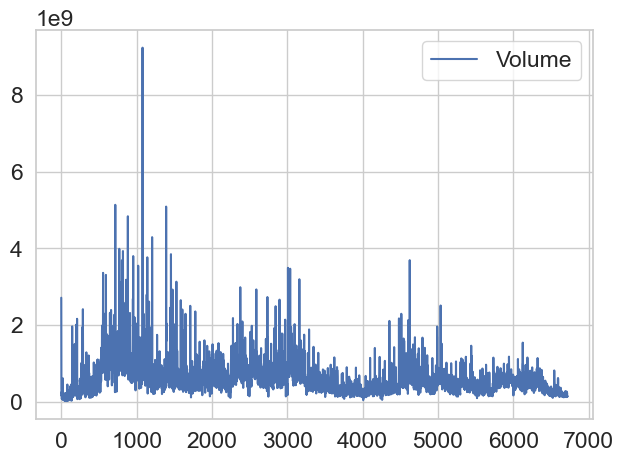

In [89]:
df[['Volume']].plot()

## 绘制各种图表

绘制 50 天和 200 天的移动平均线

移动平均线（MA）是指特定时间段内收盘价的平均值。这能让交易者清晰地了解股票或市场的趋势。

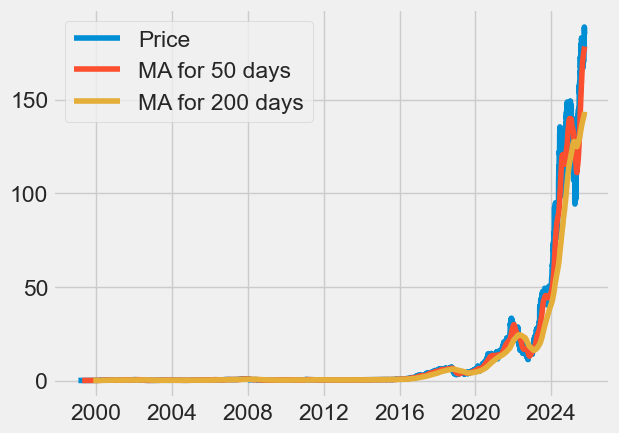

In [90]:
ma_day = [50, 200]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Close'].rolling(ma).mean()

plt.style.use("fivethirtyeight")
plt.plot(df['Date'],df[['Close', 'MA for 50 days', 'MA for 200 days']])
plt.legend(['Price', 'MA for 50 days', 'MA for 200 days'])

In [91]:
df = df.set_index('Date')

计算每日收益率

ValueError: Unrecognized marker style 'a'

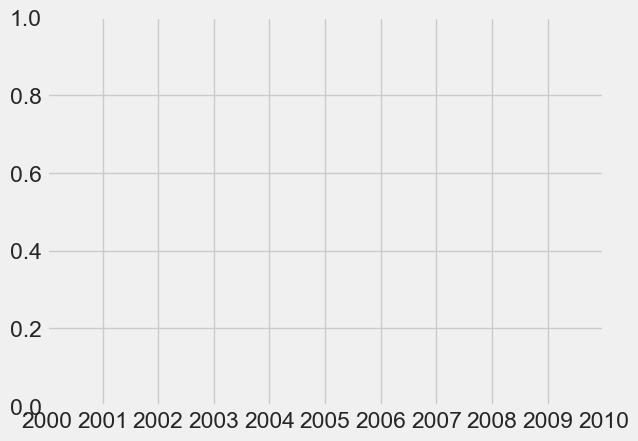

In [ ]:
df['Daily Return'] = df['Close'].pct_change()
df['Daily Return'].plot(legend=True, linestyle='', marker='o')

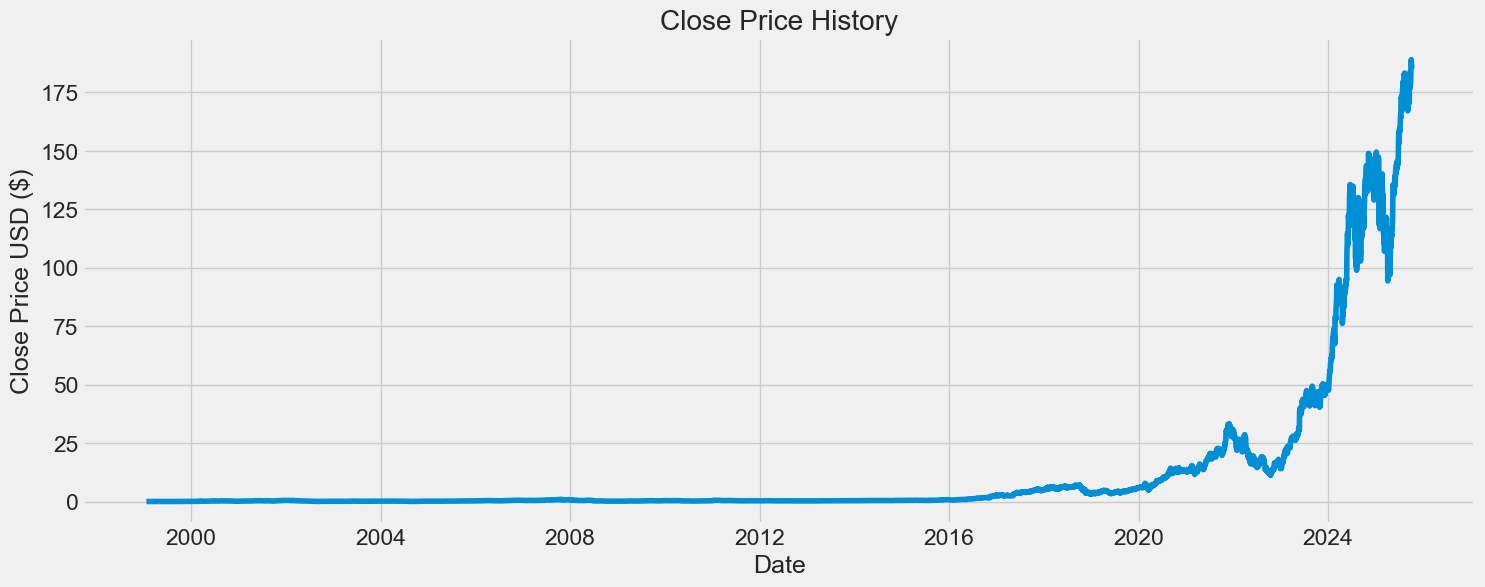

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
df.drop(["MA for 50 days","MA for 200 days","Daily Return"],axis=1,inplace=True)

In [ ]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(df[["Open","High","Low","Volume"]], df['Close'], test_size=0.05, random_state=42,shuffle=False)

## 缩放数据

最小-最大归一化是最常用的数据归一化方法之一。对于每个特征，该方法会将特征的最小值转换为0，最大值转换为1，而其他所有值都会按比例转换为0到1之间的十进制数。

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["Open","High","Low","Volume"]])


scaler_y = MinMaxScaler()
scaled_data_y = scaler_y.fit_transform(df[["Close"]])

X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data_y, test_size=0.05, random_state=42,shuffle=False)

X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test), np.array(y_train), np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape

(6383, 4, 1)

In [ ]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_train.shape

(6383, 1)

## 构建和训练模型

什么是Keras Tuner？

Keras Tuner是一个为TensorFlow程序选择最优超参数组合的库。为机器学习应用选择合适的超参数集合的过程被称为超参数调优。

In [ ]:
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model
    
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 4, executions_per_trial =2,directory = "./")

tuner.search(x=X_train, y=y_train, epochs = 10, batch_size =256, validation_data=(X_test, y_test))

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 1 summary
Hyperparameters:
input_unit: 224
n_layers: 2
lstm_0_units: 384
layer_2_neurons: 32
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 32
Score: 0.00011367415572749451

Trial 0 summary
Hyperparameters:
input_unit: 224
n_layers: 1
lstm_0_units: 224
layer_2_neurons: 96
Dropout_rate: 0.0
dense_activation: sigmoid
Score: 0.004991024499759078

Trial 3 summary
Hyperparameters:
input_unit: 160
n_layers: 2
lstm_0_units: 512
layer_2_neurons: 96
Dropout_rate: 0.2
dense_activation: sigmoid
lstm_1_units: 96
Score: 0.00500542251393199

Trial 2 summary
Hyperparameters:
input_unit: 416
n_layers: 1
lstm_0_units: 256
layer_2_neurons: 64
Dropout_rate: 0.2
dense_activation: sigmoid
lstm_1_units: 96
Score: 0.005129121243953705


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_pred = best_model.predict(X_test)

y_pred.shape

y_pred = scaler_y.inverse_transform(y_pred)
valid = pd.DataFrame(y_test0)
valid['Predicted'] = y_pred

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


## 验证模型结果并在测试数据上绘制结果图

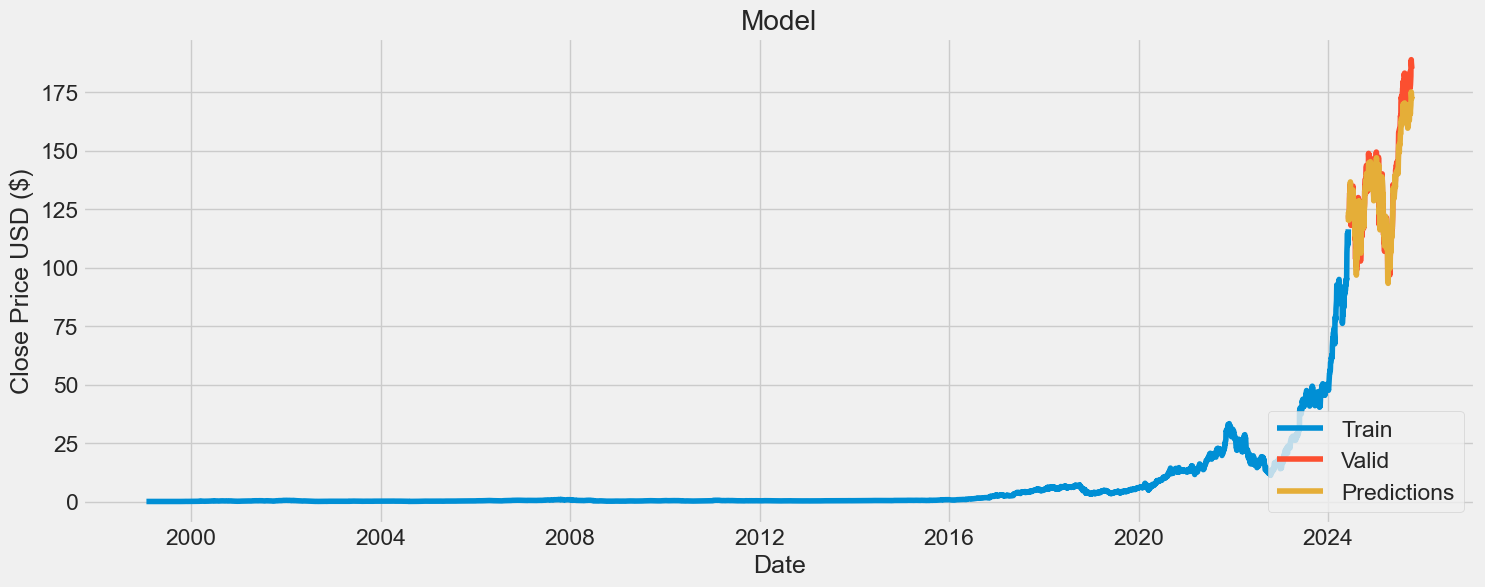

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_train0)
plt.plot(valid[['Close', 'Predicted']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

## 一、描述性分析（Descriptive Analysis）

这张图展示了 英伟达（NVIDIA）股价从 1999 年至 2024 年的走势，并叠加了：
- 蓝色 Train：用于训练模型的历史价格
- 红色 Valid：用来验证模型的真实价格
- 黄色 Predictions：LSTM 模型预测的股价

主要现象：

1. 长期股价走势呈现强烈的指数式增长
- 2000–2015 年间股价长期处于低位并平稳波动。
- 2016 年后，随着 GPU 和 AI 业务爆发，股价开始显著上升。
- 2020 年后（尤其是 2023–2024 年），出现了极其陡峭的上涨。

2. 2023–2024 年验证集（红色）价格显著高于历史区间

验证区部分是整个图中波动最大、涨幅最高的区域。

3. 模型预测（黄色）大致跟随验证集趋势
- 大体趋势跟随真实价格，但峰值明显低于真实值。
- 在大多数时间段 预测滞后 真实走势。


## 二、诊断性分析（Diagnostic Analysis）

诊断性分析用于回答：

“为什么预测与真实走势存在差距？”

“模型为何表现成这样？”

1. LSTM 难以捕捉英伟达的突发性爆发行情

英伟达 2023–2024 的上涨属于：
- 非线性、突发性上涨
- 强烈外部驱动（AI 芯片需求爆发）
- 属于历史上无先例的价格跃迁

诊断：由于模型基于过去窗口训练，而过去从未出现如此陡峭的上涨，因此 LSTM 拟合不到这种新模式。

2. 使用归一化（Normalization）导致模型对“极端涨幅”不敏感

常用 MinMaxScaler 会压缩未来高价格，导致预测被“拉回”历史尺度。

诊断：预测值被压缩在靠近历史区间内，难以达到真实的高价。

3. 训练集和验证集分布差异过大（数据漂移 Data Drift）
- 训练集（蓝色）整体平滑且低价
- 验证集（红色）波动剧烈且高价

模型面对的其实是两套完全不同的数据分布。

诊断：这是典型的 分布漂移（distribution shift），模型缺乏适应验证集的激烈变化。

4. LSTM 对长期趋势捕捉有限（序列长度不足）

大多数 notebook 使用窗口大小（lookback）通常是 60 天或 120 天，这对捕捉如下数值来说完全不够：
- 多年周期
- 政策变动
- 全球 AI 需求变化

诊断：模型只能看到“局部短期趋势”，忽视了宏观趋势。

5. 股价本身高度受外部事件影响（非纯时间序列现象）

如：
- ChatGPT 引爆 AI 算力需求
- NVIDIA 财报暴涨
- 竞争对手缺位
- GPU 价格和供应链变化

这些信息不包含在股价序列中，LSTM 无法学习到。

诊断：预测偏差来自缺少解释变量，是 特征缺失（Feature Missing）。

## 三、结论总结

描述性分析
- 图像展示了 1999–2024 年英伟达股价的历史趋势和模型预测。
- 股价在 2023–2024 年出现指数式爆炸增长。
- 模型预测跟随趋势但严重低估真实涨幅。

诊断性分析

预测偏差的核心原因包括：
1. 极端上涨行情前所未有，模型无法学习
2. 归一化导致预测收缩
3. 训练集与验证集分布严重不一致（数据漂移）
4. 窗口长度有限，无法学习长期结构性变化
5. 缺乏外部信息（AI 行业、财报、需求爆发等）